In [ ]:
!pip install torch
!pip install transformers
!pip install pandas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

Some usefull libraries that we will be using throught out the notebook.


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, BertConfig
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc, roc_auc_score

import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np

## Reading Data

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/ML Project Dataset/train.csv",on_bad_lines="skip")
df_test_label = pd.read_csv("/content/drive/MyDrive/ML Project Dataset/test_labels.csv",on_bad_lines="skip")
df_test_feature = pd.read_csv("/content/drive/MyDrive/ML Project Dataset/test.csv",on_bad_lines="skip")

df_test = df_test_feature.merge(df_test_label, on='id', how='inner')

df_test = df_test[df_test['toxic'] != -1]

train_df = df_train.drop(['id'], axis=1)
test_df = df_test.drop(['id'], axis=1)

## Creating Batches of Data

created Custom Class to apply tokenizer on our dataset and return as dictionary that wil contain input Ids , attention mask and labels.

- initialized toketiner and model

- created Custom class object for train and test data
 - tokenzier will add special token

   - [CLS] (Classification Token): This token is added to the beginning of each sequence.

   - [SEP] (Separator Token):  BERT processes pairs of sentences, and [SEP] is used to separate these pairs.

   - [PAD] (Padding Token): BERT processes input sequences of variable length in batches. To ensure that all sequences in a batch have the same length, padding tokens [PAD] are added to shorter sequences.

  - Truncate Token: The token of sentence greater then max_len will be truncated.

  - padding: if the token of sentence is less then max_len it will pad upto the max_len to make equal lenght input for model.

  - return input Ids and attention mask.

   -  input Ids will represent token in tokenizer vocabulary

   - The attention mask is usually a matrix of shape (batch_size, sequence_length) for our case (8,128), where each element is either 0 or 1. A value of 1 indicates that the corresponding token is not a padding token and should be attended to, while a value of 0 indicates that the token is a padding token and should be ignored.

      - The attention mask in models like BERT is applied to input embeddings, aiding in distinguishing real tokens from padding tokens. This ensures that the attention mechanism excludes padding tokens during computation, preventing inaccuracies in representation caused by irrelevant padding.

  example:

    - text: "toxic world!"

    - tokens: ['toxic', 'world', '!']

    - input_ids: [  101, 11704,  2088,   999,   102,     0,     0,     0,     0,     0]

    - text after decoding: [CLS] toxic world! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]

    - attention mask: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]


- passed custom class object with batch size and suffle data(True: Suffle Data randomly,False: don't suffle) to DataLoader that will return us whole data in bachtes form so we can pass that data to model as a Batch.





In [ ]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding="max_length",
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": label,
        }

# initialied Tokenizer and model from pretrained Bert Model
tokenizer = DistilBertTokenizer.from_pretrained("/content/drive/MyDrive/BertModel")
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=6
)


max_len = 128
train_dataset = CustomDataset(
    texts=train_df["comment_text"].values,
    labels=train_df.iloc[:, 1:].values,
    tokenizer=tokenizer,
    max_len=max_len,
)

test_dataset = CustomDataset(
    texts=test_df["comment_text"].values,
    labels=test_df.iloc[:, 1:].values,
    tokenizer=tokenizer,
    max_len=max_len,
)


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- AdamW Optimizer:
    
  we prefer using AdamW as the optimizer for this multilabel classification tasks, particularly this is great choice when working with transformer-based models such as BERT. The main advantage lies in the fact that AdamW is essentially an enhancement of the Adam optimizer, featuring a weight decay term. This incorporation of weight decay, a form of L2 regularization, is pivotal in mitigating overfitting by imposing penalties on large weights within the model.
- loss Function:

  we are not using any loss function here explicitly, just using the loss returned by model itself for backword pass. But if we see the implementation of DistilBertSequenceClassification they are using BCEWithLogitsLoss(Binary Cross Entropy with Logits) for multilable classification.

  In the case of multilabel classification, the sigmoid activation function is often applied to the logits to produce probabilities for each class independently and Binary cross entropy loss. BCEWithLogitsLoss combines the sigmoid activation and the binary cross-entropy loss calculation .


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00002)
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_loader)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")


Saving our Trained Model for Future Use.

In [ ]:
output_dir = "./FineTunedModel"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./FineTunedModel/tokenizer_config.json',
 './FineTunedModel/special_tokens_map.json',
 './FineTunedModel/vocab.txt',
 './FineTunedModel/added_tokens.json')

Initialized Tokenizer and Model from our trained model.

In [ ]:
model_name = "/content/drive/MyDrive/BertModel"
Bert_Tokenizer = DistilBertTokenizer.from_pretrained(model_name)
Bert_Model = DistilBertForSequenceClassification.from_pretrained(model_name)#.to(device)

Evaluated Our model on Testing Data and printed accuracy score and classification report that's contain Precision,Recall and F1-Score of all classes with micro, macro, weighted and sample average.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate the model
model.eval()
predictions = []
true_labels = []

Bert_Model.to(device)

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].cpu().numpy()

        outputs = Bert_Model(input_ids=input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        logits = torch.sigmoid(logits)
        predictions.extend(logits.cpu().numpy())
        true_labels.extend(labels)

prob = np.array(predictions)

predictions = (np.array(predictions) > 0.5).astype(int)
true_labels = np.array(true_labels)

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
classification_rep = classification_report(true_labels, predictions, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

print(f"Accuracy: {accuracy}")
print(classification_rep)

Evaluating: 100%|██████████| 7998/7998 [05:43<00:00, 23.28it/s]


Accuracy: 0.8701272312357373
               precision    recall  f1-score   support

        toxic       0.53      0.90      0.67      6090
 severe_toxic       0.41      0.31      0.35       367
      obscene       0.56      0.85      0.67      3691
       threat       0.42      0.63      0.50       211
       insult       0.68      0.72      0.70      3427
identity_hate       0.63      0.61      0.62       712

    micro avg       0.56      0.81      0.67     14498
    macro avg       0.54      0.67      0.59     14498
 weighted avg       0.57      0.81      0.66     14498
  samples avg       0.08      0.08      0.07     14498



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



***DistilBERT architecture***

On Right side we have DistilBERT architecture that get tokenize text as input and then apply Embedding Layer with 6 Transformer Layer and at the End Fully Connected Layer to get Predictions for 6 classes.

<img src="https://www.researchgate.net/profile/Alhassan-Mabrouk/publication/358239462/figure/fig2/AS:1120931644747777@1644262338087/The-DistilBERT-model-architecture-and-components.png" alt="DistilBert Architecture">

****
## Distil Bert Model:
  - Embedding:
      - word Embedding:
      
        layer dimension: (vocab_sze,hidden size) -> (30522,768)

        input (batch_size,max_len) -> (8,128)

        output (Batch_size,max_len,hidden size) -> (8,128,768)

      - position Embedding:
      
        layer dimension (bert_max_len,hidden size) -> (512,768)

        output (1,max_len,hidden size) -> (1,128,768)

      - both will be added and make (8,128,768) + (1,128,768) -> (8,128,768)

      - Layer Normalization: (hidden size) -> (768)

      - Dropout: drop with p=0.1

  - 6 * Transformer (six transformer layers):

      - MultiHeadAttention(12 heads):
        - Linear Layer for Query, Key and Value
        - Dot product of Query and Key
        - divide with dimension sqrt
        - applied softmax
        - dropout with p=0.1
        - now apply dot product of this output with value
        - conatenate whole head
        - linear layer
        - apply dropout with p=0.1
        - Residual Connection
        - Layer Normalization
      - Fully Connected Layer
        - dropout with p=0.1
        - Linear Layer (hidden Size,3072)
        - Linear Layer (3072, hidden Size)
        - Gelu Activation.
      - Layer Normalization
  - Pre-Classifier:
      - Linear Layer (hidden Size,hidden Size) -> (768,768)
  - DropOut with p=0.1
  - Classifier(Prediction Layer):
      - Linear Layer (hidden Size,output labels) -> (768,6)


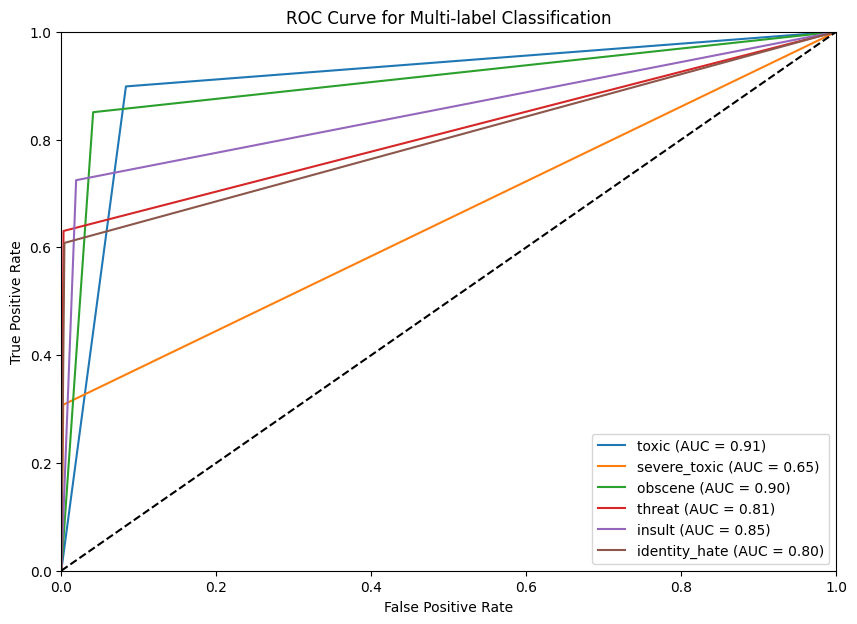

In [ ]:
# Compute ROC curve and ROC area for each class
y_test_ = np.array(true_labels)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])):
    fpr[i], tpr[i], _ = roc_curve(y_test_[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC curve for each class
plt.figure(figsize=(10, 7))
for i, label in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    plt.plot(fpr[i], tpr[i], label=f'{label} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-label Classification')
plt.legend(loc="lower right")
plt.show()


**Testing Our Model with some comment**

In [ ]:
# Set the model to evaluation mode
Bert_Model.eval()

def predict_sentence(sentence):
    # Tokenize input sentence
    inputs = Bert_Tokenizer(sentence, return_tensors="pt")

    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Forward pass to get logits
    with torch.no_grad():
        logits = Bert_Model(**inputs).logits

    # Apply sigmoid to get probabilities for each class
    probabilities = torch.sigmoid(logits)

    predicted_labels = (probabilities.cpu().numpy() > 0.5).astype(int)
    labels_list = ['toxic', 'severe_toxic', 'obscene','threat', 'insult', 'identity_hate']
    result = dict(zip(labels_list, predicted_labels[0]))

    return result

In [ ]:
sentences = [
    "You are always so stupid idiot!",
    "I can't stand your rubbish behaviour , bloody retarted.",
    "I appreciate your shit feedback.",
    "I hope you are doing well",
    "Such an Idiot person!"
]


for n in range(5):
  print("Sentence: ",sentences[n])
  predictions = predict_sentence(sentences[n])
  print(f"Predictions: {predictions}\n")

Sentence:  You are always so stupid idiot!
Predictions: {'toxic': 1, 'severe_toxic': 0, 'obscene': 1, 'threat': 0, 'insult': 1, 'identity_hate': 0}

Sentence:  I can't stand your rubbish behaviour , bloody retarted.
Predictions: {'toxic': 1, 'severe_toxic': 0, 'obscene': 1, 'threat': 0, 'insult': 1, 'identity_hate': 0}

Sentence:  I appreciate your shit feedback.
Predictions: {'toxic': 1, 'severe_toxic': 0, 'obscene': 1, 'threat': 0, 'insult': 0, 'identity_hate': 0}

Sentence:  I hope you are doing well
Predictions: {'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}

Sentence:  Such an Idiot person!
Predictions: {'toxic': 1, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 1, 'identity_hate': 0}

